# Proyek Akhir : Membuat Model Sistem Rekomendasi

Nama : Alivia Vinca Kustaryono

Cohort ID : MC006D5X2041

Email : mc006d5x2041@student.devacademy.id

# Data Loading

## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from zipfile import ZipFile

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import warnings
warnings.filterwarnings('ignore')


## Upload dan ekstrak dataset

In [2]:
# Import module yang disediakan google colab untuk kebutuhan upload file
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"mc006d5x2041","key":"9cbfefc7928603e51e693b7df8e126d6"}'}

In [3]:
# Download kaggle dataset dan unzip file
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d CooperUnion/anime-recommendations-database

Dataset URL: https://www.kaggle.com/datasets/CooperUnion/anime-recommendations-database
License(s): CC0-1.0
  0% 0.00/25.0M [00:00<?, ?B/s]
100% 25.0M/25.0M [00:00<00:00, 1.08GB/s]


In [5]:
!unzip anime-recommendations-database.zip

Archive:  anime-recommendations-database.zip
  inflating: anime.csv               
  inflating: rating.csv              


## Load Dataset

In [6]:
# Baca dataset CSV
anime = pd.read_csv('anime.csv')
rating = pd.read_csv('rating.csv')

In [7]:
anime.head()

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


In [8]:
rating.head()

,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1


# Exploratory Data Analysis (EDA)

## Struktur Data

In [9]:
# Cek informasi dataset
anime.info()
print('-----------------------------------------------------------')
rating.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12294 entries, 0 to 12293
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   anime_id  12294 non-null  int64  
 1   name      12294 non-null  object 
 2   genre     12232 non-null  object 
 3   type      12269 non-null  object 
 4   episodes  12294 non-null  object 
 5   rating    12064 non-null  float64
 6   members   12294 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 672.5+ KB
-----------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7813737 entries, 0 to 7813736
Data columns (total 3 columns):
 #   Column    Dtype
---  ------    -----
 0   user_id   int64
 1   anime_id  int64
 2   rating    int64
dtypes: int64(3)
memory usage: 178.8 MB


In [ ]:
# Cek jumlah baris dan kolom
print(anime.shape)
print('-----------------------------------------------------------')
print(rating.shape)

(12294, 7)
-----------------------------------------------------------
(7813737, 3)


In [ ]:
# Statistik deskriptif
anime.describe()

,anime_id,rating,members
count,12294.000000,12064.000000,1.229400e+04
mean,14058.221653,6.473902,1.807134e+04
std,11455.294701,1.026746,5.482068e+04
min,1.000000,1.670000,5.000000e+00
25%,3484.250000,5.880000,2.250000e+02
50%,10260.500000,6.570000,1.550000e+03
75%,24794.500000,7.180000,9.437000e+03
max,34527.000000,10.000000,1.013917e+06


In [ ]:
rating.describe()

,user_id,anime_id,rating
count,7.813737e+06,7.813737e+06,7.813737e+06
mean,3.672796e+04,8.909072e+03,6.144030e+00
std,2.099795e+04,8.883950e+03,3.727800e+00
min,1.000000e+00,1.000000e+00,-1.000000e+00
25%,1.897400e+04,1.240000e+03,6.000000e+00
50%,3.679100e+04,6.213000e+03,7.000000e+00
75%,5.475700e+04,1.409300e+04,9.000000e+00
max,7.351600e+04,3.451900e+04,1.000000e+01


In [ ]:
# Cek data kosong
anime.isnull().sum()

,0
anime_id,0
name,0
genre,62
type,25
episodes,0
rating,230
members,0


In [ ]:
rating.isnull().sum()

,0
user_id,0
anime_id,0
rating,0


In [10]:
# Cek jumlah data duplikat
anime.duplicated().sum()

np.int64(0)

In [11]:
rating.duplicated().sum()

np.int64(1)

## Visualisasi Genre dan Tipe Anime

In [ ]:
# Menghitung genre anime
genres = anime['genre'].dropna().str.cat(sep=',').split(',')
genres = pd.Series(genres).value_counts()
genres.head(20)

,count
Comedy,3193
Action,2845
Sci-Fi,1986
Fantasy,1815
Shounen,1663
Adventure,1457
Comedy,1452
Romance,1371
Kids,1213
School,1170


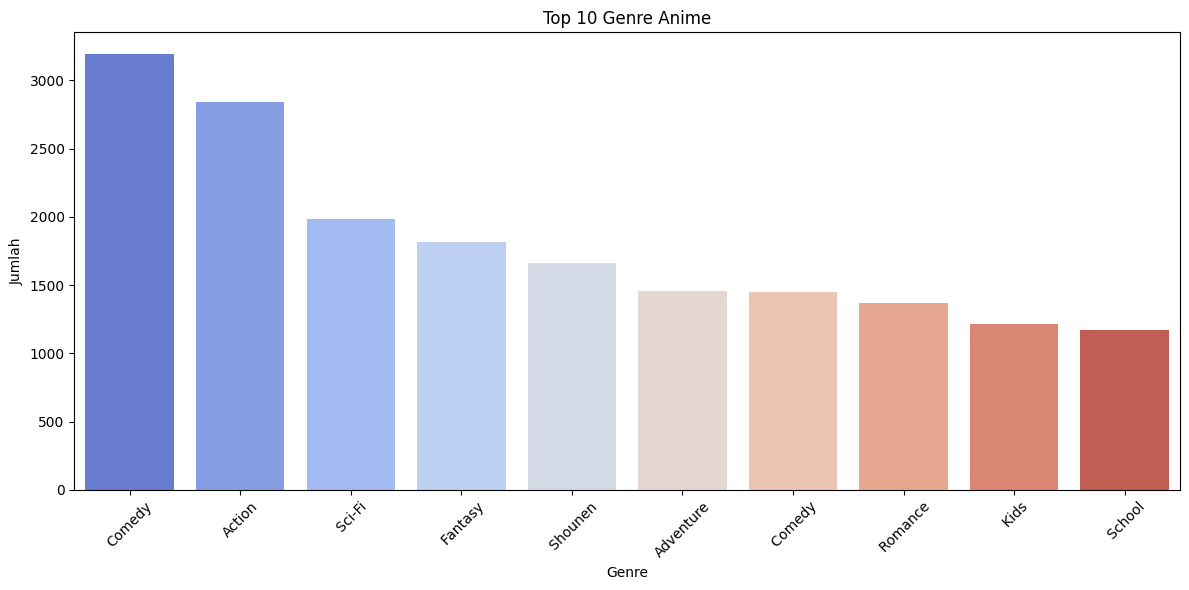

In [ ]:
# Visualisasi genre anime
plt.figure(figsize=(12, 6))
sns.barplot(
    x=genres.head(10).index,
    y=genres.head(10).values,
    palette=sns.color_palette("coolwarm", n_colors=10)
)
plt.title('Top 10 Genre Anime')
plt.xlabel('Genre')
plt.ylabel('Jumlah')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# Menghitung tipe anime
tipe_anime = anime['type'].value_counts()
tipe_anime

,count
type,
TV,3787
OVA,3311
Movie,2348
Special,1676
ONA,659
Music,488


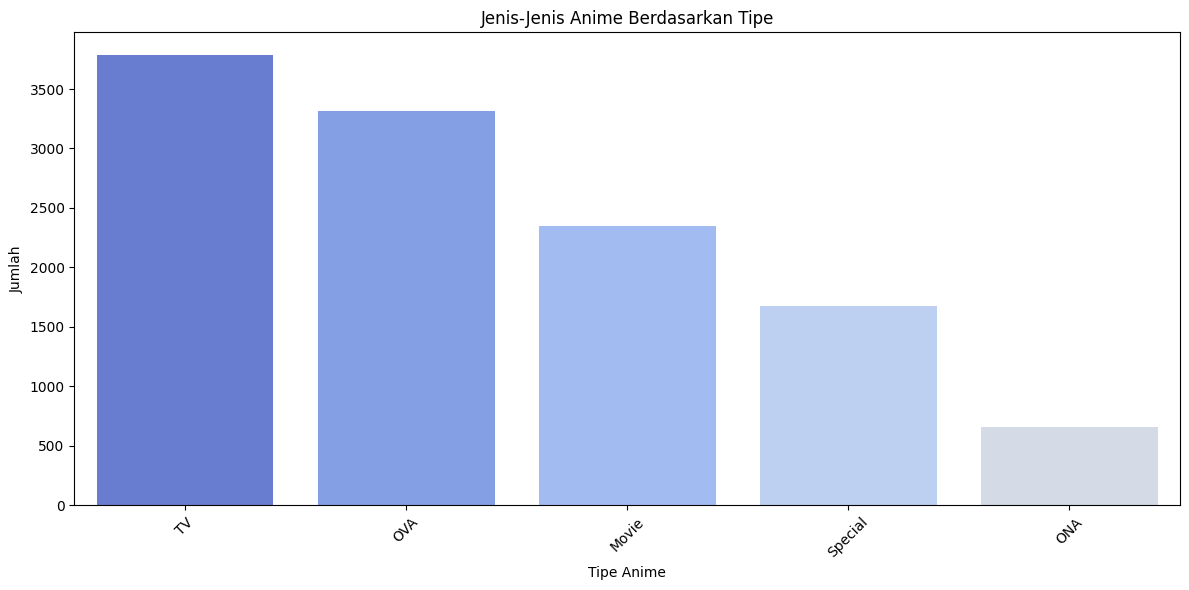

In [ ]:
# Visualisasi tipe anime
plt.figure(figsize=(12, 6))
sns.barplot(
    x=tipe_anime.head().index,
    y=tipe_anime.head().values,
    palette=sns.color_palette("coolwarm", n_colors=10)
)
plt.title('Jenis-Jenis Anime Berdasarkan Tipe')
plt.xlabel('Tipe Anime')
plt.ylabel('Jumlah')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Data Preprocessing

1. Sampling 50000 Rating

In [12]:
# Sampling 50000 Rating
rating_sample = rating.sample(n=50000, random_state=42)

In [13]:
rating_sample.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50000 entries, 7806172 to 7241830
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   user_id   50000 non-null  int64
 1   anime_id  50000 non-null  int64
 2   rating    50000 non-null  int64
dtypes: int64(3)
memory usage: 1.5 MB


In [14]:
rating_sample.head()

,user_id,anime_id,rating
7806172,73424,7785,10
6470262,59789,19769,6
5975474,55960,59,10
7617688,71461,3342,10
5932334,55390,986,8


2. Membersihkan kolom kosong pada dataset anime

In [15]:
# Membersihkan kolom kosong

# Isi missing value pada kolom 'genre' dengan 'Unknown'
anime['genre'] = anime['genre'].fillna('Unknown')

# Isi missing value pada kolom 'type' dengan 'Unknown'
anime['type'] = anime['type'].fillna('Unknown')

# Isi missing value pada kolom 'rating' dengan 0.00
anime['rating'] = anime['rating'].fillna(0.00)


In [16]:
anime.isnull().sum()

,0
anime_id,0
name,0
genre,0
type,0
episodes,0
rating,0
members,0


3. Membersihkan nama anime dari karakter non-alfabetnumerik

In [17]:
# Membersihkan Nama Anime
anime['name'] = anime['name'].str.replace(r'[^a-zA-Z0-9\s]', '', regex=True)

In [18]:
anime.head()

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,SteinsGate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama039,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


4. Standarisasi genre anime menjadi hanya satu genre pertamanya

In [19]:
# Standarisasi genre anime
anime['genre'] = anime['genre'].apply(lambda x: x.split(',')[0].strip())

In [20]:
general_genre = anime.groupby('name')['genre'].agg(lambda x: x.mode().iloc[0]).reset_index()

In [21]:
anime = anime.drop(columns='genre').merge(general_genre, on='name').rename(columns={'genre': 'genre'})

In [22]:
anime.head()

,anime_id,name,type,episodes,rating,members,genre
0,32281,Kimi no Na wa,Movie,1,9.37,200630,Drama
1,5114,Fullmetal Alchemist Brotherhood,TV,64,9.26,793665,Action
2,28977,Gintama,TV,51,9.25,114262,Action
3,9253,SteinsGate,TV,24,9.17,673572,Sci-Fi
4,9969,Gintama039,TV,51,9.16,151266,Action


# Model Development Content Based Filtering

In [23]:
# Menampilkan data kolom nama dan genre
anime[['name','genre']].head()

,name,genre
0,Kimi no Na wa,Drama
1,Fullmetal Alchemist Brotherhood,Action
2,Gintama,Action
3,SteinsGate,Sci-Fi
4,Gintama039,Action


## TF-IDF Vectorizer

In [24]:
# Inisialisasi TfidfVectorizer
tfidf = TfidfVectorizer()

# Melakukan perhitungan idf pada data genre
tfidf.fit(anime['genre'])

# Mapping array dari fitur index integer ke fitur nama
tfidf.get_feature_names_out()

array(['action', 'adventure', 'arts', 'cars', 'comedy', 'dementia',
       'demons', 'drama', 'ecchi', 'fantasy', 'fi', 'game', 'harem',
       'hentai', 'historical', 'horror', 'josei', 'kids', 'life', 'magic',
       'martial', 'mecha', 'military', 'music', 'mystery', 'of', 'parody',
       'police', 'power', 'psychological', 'romance', 'samurai', 'school',
       'sci', 'seinen', 'shoujo', 'shounen', 'slice', 'space', 'sports',
       'super', 'supernatural', 'thriller', 'unknown', 'vampire', 'yaoi'],
      dtype=object)

In [25]:
# Transformasi genre ke bentuk matriks TF-IDF
tfidf_matrix = tfidf.fit_transform(anime['genre'])

# Melihat ukuran matriks TF-IDF
print("Ukuran Matrix TF-IDF:", tfidf_matrix.shape)

Ukuran Matrix TF-IDF: (12294, 46)


In [26]:
# Mengubah vektor TF-IDF dalam bentuk matriks
tfidf_matrix.todense()

matrix([[0., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])

In [27]:
# Membuat dataframe untuk melihat matrix TF-IDF
pd.DataFrame(
    tfidf_matrix.todense(),
    columns=tfidf.get_feature_names_out(),
    index=anime['name']
)

,action,adventure,arts,cars,comedy,dementia,demons,drama,ecchi,fantasy,...,shounen,slice,space,sports,super,supernatural,thriller,unknown,vampire,yaoi
name,,,,,,,,,,,,,,,,,,,,,
Kimi no Na wa,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Fullmetal Alchemist Brotherhood,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Gintama,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SteinsGate,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Gintama039,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Toushindai My Lover Minami tai MechaMinami,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Under World,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Violence Gekiga David no Hoshi,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Cosine Similarity

In [28]:
# Menghitung cosine similarity pada matrix tf-idf
cosine_sim = cosine_similarity(tfidf_matrix)
cosine_sim

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 1., 1.],
       [0., 0., 0., ..., 1., 1., 1.],
       [0., 0., 0., ..., 1., 1., 1.]])

In [29]:
# Membuat dataframe cosine similiarity antar anime
cosine_sim_df = pd.DataFrame(cosine_sim, index=anime['name'], columns=anime['name'])

# Menampilkan ukuran matriks cosine similiarity
print('Shape:', cosine_sim_df.shape)

# Melihat similarity matrix pada setiap anime
cosine_sim_df.sample(5, axis=1).sample(10, axis=0)

Shape: (12294, 12294)


name,Koguma no Misha,Kyouhaku II Second Mou Hitotsu no Ashita The Animation,Mushi no Tameiki,Kappa no Coo to Natsuyasumi,Utawarerumono Specials
name,,,,,
Oshaburi Announcer,0.0,1.0,0.0,0.0,0.0
Shigatsu wa Kimi no Uso,0.0,0.0,0.0,0.0,0.0
Kuroko no Basket Movie 3 Winter Cup Soushuuhen Tobira no Mukou,0.0,0.0,0.0,0.0,0.0
Hinadori no Saezuri,0.0,1.0,0.0,0.0,0.0
Hustle Tokitamakun,0.0,0.0,0.0,0.0,0.0
Spriggan,1.0,0.0,0.0,1.0,0.0
X Double X,0.0,0.0,0.0,0.0,0.0
Kkomaeosa Ttori,0.0,0.0,0.0,0.0,1.0
Asylum Session,0.0,0.0,0.0,0.0,0.0


### Mendapatkan Rekomendasi

In [30]:
def anime_recommendations(anime_name, similarity_data=cosine_sim_df, items=anime[['name', 'genre']], k=5):
    """
    Rekomendasi Anime berdasarkan kemiripan dataframe

    Parameter:
    ---
    nama_anime : tipe data string (str)
                 Nama Anime (index kemiripan dataframe)
    similarity_data : tipe data pd.DataFrame (object)
                      Kesamaan dataframe, simetris, dengan anime sebagai indeks dan kolom
    items : tipe data pd.DataFrame (object)
            Mengandung kedua nama dan fitur lainnya yang digunakan untuk mendefinisikan kemiripan
    k : tipe data integer (int)
        Banyaknya jumlah rekomendasi yang diberikan
    ---

    Pada index ini, kita mengambil k dengan nilai similarity terbesar
    pada index matrix yang diberikan (i).
    """
    # Mengambil data dengan menggunakan argpartition untuk melakukan partisi secara tidak langsung sepanjang sumbu yang diberikan
    # Dataframe diubah menjadi numpy
    # Range(start, stop, step)
    index = similarity_data.loc[:,anime_name].to_numpy().argpartition(range(-1, -k, -1))

    # Mengambil data dengan similarity terbesar dari index yang ada
    closest = similarity_data.columns[index[-1:-(k+2):-1]]

    # Drop nama_movie agar nama movie yang dicari tidak muncul dalam daftar rekomendasi
    closest = closest.drop(anime_name, errors='ignore')

    return pd.DataFrame(closest).merge(items).head(k)

In [31]:
# Cek data anime
anime[anime['name'].eq('Sword Art Online')]

,anime_id,name,type,episodes,rating,members,genre
804,11757,Sword Art Online,TV,25,7.83,893100,Action


In [32]:
# Mendapatkan rekomendasi anime mirip dengan anime yang di panggil
anime_recommendations('Sword Art Online')

,name,genre
0,Arabian Nights Sindbad no Bouken,Action
1,Offside,Action
2,Ghost in the Shell Arise Episode jp,Action
3,iDOLMSTER Xenoglossia,Action
4,GantzO,Action


# Model Development dengan Collaborative Filtering

In [33]:
# Menampilkan data rating yang sudah di sampling
rating_sample.head()

,user_id,anime_id,rating
7806172,73424,7785,10
6470262,59789,19769,6
5975474,55960,59,10
7617688,71461,3342,10
5932334,55390,986,8


### Data Preparation

In [34]:
#Filter rating

# Hapus rating yang tidak valid (−1)
rating_sample = rating_sample[rating_sample['rating'] != -1]

# Mengambil anime dari dataset anime
rating_sample = rating_sample[rating_sample['anime_id'].isin(anime['anime_id'])]

# Filter user dengan minimal 5 rating
user_counts = rating_sample['user_id'].value_counts()
active_users = user_counts[user_counts >= 5].index
rating_sample = rating_sample[rating_sample['user_id'].isin(active_users)]

# Reset index setelah filter
rating_sample.reset_index(drop=True, inplace=True)

# Info data setelah preprocessing
print("Shape anime:", anime.shape)
print("Shape rating_sample:", rating_sample.shape)
print("Sample rating_sample:")
print(rating_sample.head())


Shape anime: (12294, 7)
Shape rating_sample: (6939, 3)
Sample rating_sample:
   user_id  anime_id  rating
0    21160     14345      10
1    51693      8312       7
2    56577      8630       7
3    48485      1535      10
4    21208      9041      10


In [35]:
# Encode user_id dan anime_id menjadi index numerik
user_ids = rating_sample['user_id'].unique().tolist()
anime_ids = rating_sample['anime_id'].unique().tolist()

user2user_encoded = {x: i for i, x in enumerate(user_ids)}
anime2anime_encoded = {x: i for i, x in enumerate(anime_ids)}

rating_sample['user'] = rating_sample['user_id'].map(user2user_encoded)
rating_sample['anime'] = rating_sample['anime_id'].map(anime2anime_encoded)

# Tentukan jumlah user dan anime
num_users = len(user2user_encoded)
num_anime = len(anime2anime_encoded)

print(f'Jumlah users: {num_users}, Jumlah anime: {num_anime}')

Jumlah users: 1086, Jumlah anime: 2866


### Membagi Data untuk Training dan Validasi

In [39]:
# Split data train dan validasi

# Membuat variabel x untuk mencocokkan data user dan resto menjadi satu value
x = rating_sample[['user', 'anime']].values

# Membuat variabel y untuk membuat rating dari hasil
y = rating_sample['rating'].values

print(f"Jumlah rating akhir: {rating_sample.shape[0]}")

# Membagi menjadi 80% data train dan 20% data validasi
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=42)

print(f"x_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"x_val shape: {x_val.shape}")
print(f"y_val shape: {y_val.shape}")
print(x, y)

Jumlah rating akhir: 6939
x_train shape: (5551, 2)
y_train shape: (5551,)
x_val shape: (1388, 2)
y_val shape: (1388,)
[[   0    0]
 [   1    1]
 [   2    2]
 ...
 [ 179 1631]
 [ 763 2864]
 [ 740 2865]] [10  7  7 ...  5  7  8]


### Proses Training

In [37]:
class RecommenderNet(tf.keras.Model):

  # Insialisasi fungsi
  def __init__(self, num_users, num_anime, embedding_size, **kwargs):
    super(RecommenderNet, self).__init__(**kwargs)
    self.num_users = num_users
    self.num_anime = num_anime
    self.embedding_size = embedding_size

    self.user_embedding = layers.Embedding( # layer embedding user
        num_users,
        embedding_size,
        embeddings_initializer = 'he_normal',
        embeddings_regularizer = keras.regularizers.l2(1e-6)
    )
    self.user_bias = layers.Embedding(num_users, 1) # layer embedding user bias
    self.anime_embedding = layers.Embedding( # layer embeddings movie
        num_anime,
        embedding_size,
        embeddings_initializer = 'he_normal',
        embeddings_regularizer = keras.regularizers.l2(1e-6)
    )
    self.anime_bias = layers.Embedding(num_anime, 1) # layer embedding movie bias

  def call(self, inputs):
    user_vector = self.user_embedding(inputs[:,0]) # memanggil layer embedding 1
    user_bias = self.user_bias(inputs[:, 0]) # memanggil layer embedding 2
    anime_vector = self.anime_embedding(inputs[:, 1]) # memanggil layer embedding 3
    anime_bias = self.anime_bias(inputs[:, 1]) # memanggil layer embedding 4

    dot_user_anime = tf.tensordot(user_vector, anime_vector, 2)

    x = dot_user_anime + user_bias + anime_bias
    # Menggunakan sigmoid hanya jika output rating 0-1.
    # Jika rating 1-10, jangan gunakan sigmoid dan pertimbangkan Mean Squared Error sebagai loss.
    return x

In [38]:
model = RecommenderNet(num_users, num_anime, 50) # inisialisasi model

# model compile
model.compile(
    loss = tf.keras.losses.MeanSquaredError(),
    optimizer = keras.optimizers.Adam(learning_rate=0.001),
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

### Training model

In [40]:
# Training Training Model
print("\nMemulai proses training model...")
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=32, # Ukuran batch yang lebih kecil dari tf.data.Dataset batch (1024)
                    # karena ini adalah batch untuk proses training di Keras fit
    epochs=50,      # Jumlah epoch, sesuaikan sesuai kebutuhan dan kinerja
    validation_data=(x_val, y_val),
    verbose=1       # Menampilkan progress training
)
print("\nProses training selesai.")



Memulai proses training model...
Epoch 1/50
174/174 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 57.7598 - root_mean_squared_error: 7.5999 - val_loss: 57.5541 - val_root_mean_squared_error: 7.5864
Epoch 2/50
174/174 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 48.4209 - root_mean_squared_error: 6.9585 - val_loss: 56.9437 - val_root_mean_squared_error: 7.5461
Epoch 3/50
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 35.0864 - root_mean_squared_error: 5.9227 - val_loss: 56.3951 - val_root_mean_squared_error: 7.5096
Epoch 4/50
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 17.1450 - root_mean_squared_error: 4.1395 - val_loss: 55.8989 - val_root_mean_squared_error: 7.4765
Epoch 5/50
174/174 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 5.4078 - root_mean_squared_error: 2.3230 - val_loss: 55.6197 - val_root_mean_squared_error: 7.4578
Epoch 6/50
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.7327 - root_mean_squared_error: 1.6523 - val_loss: 55.5272 - val_root_mean_squared_error: 7.4516
Epoch 7/

In [41]:
# Hasil Evaluasi dengan MSE & RMSE
results = model.evaluate(x_val, y_val, verbose=1)

print("\nHasil Evaluasi pada Data Validasi:")
print(f"Loss (MSE): {results[0]:.4f}")
print(f"RMSE: {results[1]:.4f}")

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 53.7579 - root_mean_squared_error: 7.3316

Hasil Evaluasi pada Data Validasi:
Loss (MSE): 53.2460
RMSE: 7.2969


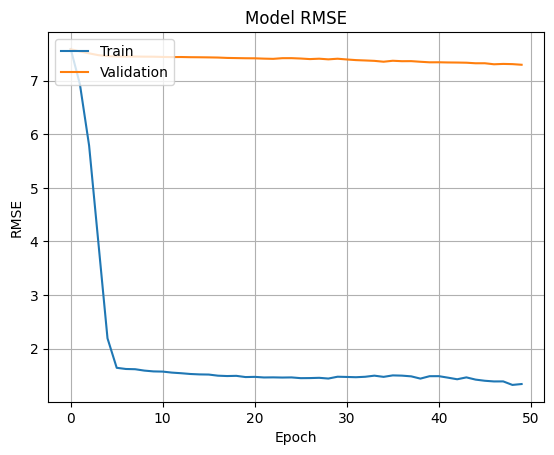

In [42]:
# Visualisasi metrik
def plot_rmse(history):
    plt.plot(history.history['root_mean_squared_error'])
    plt.plot(history.history['val_root_mean_squared_error'])
    plt.title('Model RMSE')
    plt.ylabel('RMSE')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.grid(True)
    plt.show()
plot_rmse(history)

### Mendapatkan Rekomendasi

In [43]:
anime_df = anime.copy()
rating_df = rating_sample.copy()

# Mengambil sample user
userId = rating_sample.user_id.sample(1).iloc[0]
anime_watched_by_user = rating_sample[rating_sample.user_id == userId]

# Operator bitwise (~), bisa diketahui di sini https://docs.python.org/3/reference/expressions.html
anime_not_watched_ids = anime_df[~anime_df['anime_id'].isin(anime_watched_by_user.anime_id.values)]['anime_id']
encoded_user_id = user2user_encoded[userId]
encoded_anime_not_watched = [anime2anime_encoded.get(anime_id) for anime_id in anime_not_watched_ids if anime_id in anime2anime_encoded]

user_anime_array = np.hstack((
    np.array([[encoded_user_id]] * len(encoded_anime_not_watched)),
    np.array(encoded_anime_not_watched).reshape(-1, 1)
))

In [44]:
ratings = model.predict(user_anime_array).flatten()

# Ambil indeks dengan prediksi rating tertinggi
top_ratings_indices = ratings.argsort()[-10:][::-1]

# Karena kita pakai ID asli, ambil langsung dari anime_not_watched
recommended_anime_ids = [anime_not_watched_ids.iloc[x] for x in top_ratings_indices]

print('Showing recommendations for user:', userId)
print('===' * 9)
print('Anime with high ratings from user')
print('----' * 8)

# Ambil 5 anime dengan rating tertinggi dari user tersebut
top_anime_user_ids = (
    anime_watched_by_user.sort_values(
        by='rating',
        ascending=False
    )
    .head(5)
    .anime_id.values
)

# Tampilkan anime yang sudah pernah ditonton dan disukai user
anime_df_rows = anime_df[anime_df['anime_id'].isin(top_anime_user_ids)]
for row in anime_df_rows.itertuples():
    print(row.name, ':', row.genre)

print('----' * 8)
print('Top 10 anime recommendation')
print('----' * 8)

# Tampilkan anime hasil rekomendasi model
recommended_anime = anime_df[anime_df['anime_id'].isin(recommended_anime_ids)]
for row in recommended_anime.itertuples():
    print(row.name, ':', row.genre)

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Showing recommendations for user: 41950
Anime with high ratings from user
--------------------------------
Major World Series : Comedy
Noragami : Action
Digimon Adventure : Action
Life no Color : Music
AfroKen : Comedy
--------------------------------
Top 10 anime recommendation
--------------------------------
Mahou Shoujo MadokaMagica : Drama
Magi The Kingdom of Magic : Action
Mahou Shoujo MadokaMagica Movie 3 Hangyaku no Monogatari : Drama
Katanagatari : Action
Major S6 : Comedy
Mononoke : Demons
Noragami Aragoto : Action
Tonari no Totoro : Adventure
Ookami to Koushinryou II : Adventure
Gintama Nanigoto mo Saiyo ga Kanjin nano de Tasho Senobisuru Kurai ga Choudoyoi : Action
